In [ ]:
# 

In [633]:
import pandas as pd
from pathlib import Path
import sqlite3
from datetime import datetime
import traceback
import dtale
import re
import math
import geopandas as gpd

# Move data to sql database for easier querying and connectecting

In [23]:
list(Path('data').glob('*.csv'))

[PosixPath('data/books.csv'),
 PosixPath('data/libraries.csv'),
 PosixPath('data/checkouts.csv'),
 PosixPath('data/customers.csv')]

In [19]:
# str(a)

In [22]:
conn = sqlite3.connect("data/library_example.db")  # This will create 'example.db' in the current directory

# conn.close()

In [21]:
for csv_path in Path('data').glob('*.csv'):
    table_name = csv_path.stem
    print(table_name)
    temp_df = pd.read_csv(csv_path)
    temp_df.to_sql(name=table_name, con=conn, if_exists="replace", index=False)

conn.close()

books
libraries
checkouts
customers


In [131]:
checkouts_df = pd.read_csv('data/checkouts.csv')

In [103]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2019-01-28,2018-11-13
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12


In [104]:
checkouts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2000 non-null   object
 1   patron_id      2000 non-null   object
 2   library_id     2000 non-null   object
 3   date_checkout  1935 non-null   object
 4   date_returned  1942 non-null   object
dtypes: object(5)
memory usage: 78.3+ KB


In [105]:
# checkouts_df['date_checkout'] = pd.to_datetime(checkouts_df['date_checkout'], format='mixed')
# checkouts_df['date_returned'] = pd.to_datetime(checkouts_df['date_returned'], format='mixed')

In [106]:
# date_str

Since PDF with assigments has been created 2021-04-09, and dataset has not 2021 and 2017 in it, I will use those as cutoff dates.

In [135]:
checkouts_df["date_returned"] = checkouts_df["date_returned"].fillna('')
checkouts_df[checkouts_df["date_returned"].str.contains('2021')]


,id,patron_id,library_id,date_checkout,date_returned


In [136]:
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].fillna('')
checkouts_df[checkouts_df["date_checkout"].str.contains('2021')]

,id,patron_id,library_id,date_checkout,date_returned


In [999]:
checkouts_df = pd.read_csv('data/checkouts.csv')

In [1000]:
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].fillna('2017-12-31') # this is bad data
checkouts_df["date_returned"] = checkouts_df["date_returned"].fillna('2021-04-09') # not yet returned

We have many different date formats, dates in the past, dates in the future. This would prompt me to get in touch with aplicaiton developers to implement data verification on data entry form. This is not only affecting our analisys, but work of the libraries.  

In [1001]:
date_formats = ["%Y-%m-%d", "%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", "%Y", "%Y-%m"]

# Function to check if a date matches any of the specified formats
def is_valid_date(date_str, formats):
    date_str = date_str.replace('%', '')
    date_str = date_str.strip()

    for fmt in formats:
        try:
            # Try to parse the date with the current format
            return datetime.strptime(date_str, fmt)
        except Exception as e:

            continue
    print(date_str)
    return None 


# Apply the function to check validity of each date
checkouts_df["date_checkout"] = checkouts_df["date_checkout"].apply(lambda x: is_valid_date(x, date_formats))
checkouts_df["date_returned"] = checkouts_df["date_returned"].apply(lambda x: is_valid_date(x, date_formats))

In [1002]:
checkouts_df['length'] = checkouts_df.date_returned - checkouts_df.date_checkout
checkouts_df['length'] = checkouts_df.length.dt.days

In [1003]:
# date_checkout before 2018-01-01 are all 1800 and invalid, including 2017-12-31 which is NA
checkouts_df[checkouts_df.date_checkout<='2017-12-31'].shape 

(155, 6)

In [1004]:
checkouts_df = checkouts_df[checkouts_df.date_checkout>'2017-12-31']

loans retruned after 2021-04-09 are illegal dates, not contributing to our analisys

In [1005]:
checkouts_df[checkouts_df.date_returned>'2021-04-09'].shape

(95, 6)

In [1006]:
checkouts_df[checkouts_df.date_returned=='2021-04-09'].shape

(58, 6)

In [1007]:
checkouts_df = checkouts_df[checkouts_df.date_returned<='2021-04-09']

In [1008]:
checkouts_df[checkouts_df.length<0].shape

(241, 6)

In [1009]:
checkouts_df = checkouts_df[~checkouts_df.length<0]

In [1010]:
checkouts_df[checkouts_df.length<=28].shape

(1319, 6)

In [1011]:
checkouts_df[checkouts_df.length<=28].shape

(1319, 6)

<Axes: >

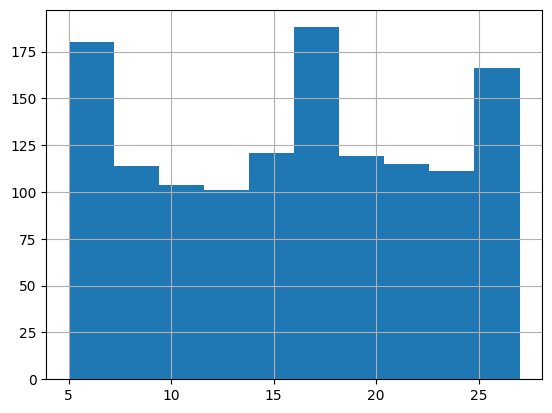

In [1012]:
checkouts_df[checkouts_df.length<=28].length.hist()

Data looks sythetic, I would expect  Poisson Probability Distribution here, while this is more uniform, let's see further. Maybe 28 day cutoff is affecting distribution.

In [1013]:
checkouts_df[checkouts_df.length>28].shape

(190, 6)

<Axes: >

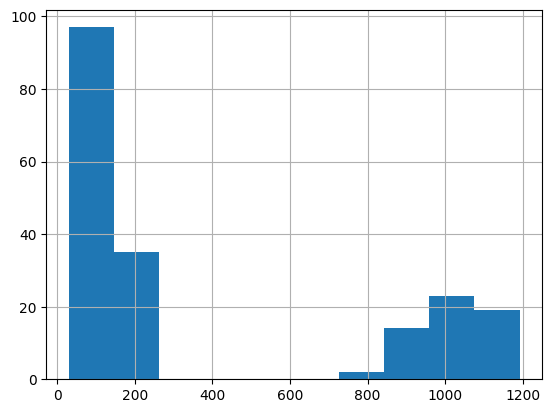

In [1014]:
checkouts_df[checkouts_df.length>28].length.hist()

In [1015]:
# dtale.show(checkouts_df.sort_values(by='date_checkout'))

In [1016]:
checkouts_df.to_csv('data/checkouts_df_clean.csv')

In [1017]:
checkouts_df.to_pickle('data/checkouts_df.pickle')

In [1018]:
checkouts_df = pd.read_pickle('data/checkouts_df.pickle')

In [1019]:
checkouts_df

,id,patron_id,library_id,date_checkout,date_returned,length
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25,100
6,CW-7tHAaVR0C,dd9f34e9d65126a2b02003d8ac60aaa4,22c-222@5xc-jwj-pvz,2018-01-10,2018-02-04,25
8,t1e3BWziAc8C,3b85b2c7b424618f533329018e9a11d5,222-222@5xc-jv5-nt9,2018-06-23,2018-07-14,21
...,...,...,...,...,...,...
1995,rNbuDwAAQBAJ,91871955f3641857832766ac3f5a0b95,222-222@5xc-jv5-nt9,2018-07-19,2018-08-12,24
1996,rcrCAgAAQBAJ,ad08956eb20efb746af650f906d439cf,22d-222@5xc-kcy-8sq,2018-03-07,2018-03-13,6
1997,F44fAQAAMAAJ,026262cc3454149303074c4113b5f118,226-222@5xc-jxj-7yv,2018-06-17,2018-06-27,10
1998,Ci1HAQAAMAAJ,08b29865e58e9b2aabff9684a703acf0,223-222@5xc-jxr-tgk,2018-12-10,2018-12-29,19


# Books

In [335]:
books_df = pd.read_csv('data/books.csv').add_prefix('book_')

In [336]:
books_df.columns

Index(['book_id', 'book_title', 'book_authors', 'book_publisher',
       'book_publishedDate', 'book_categories', 'book_price', 'book_pages'],
      dtype='object')

In [337]:
def clean_price(price):
    # Keep only valid float characters (digits, '.', '-', optional ',' for formatting)
    cleaned = re.sub(r"[^\d\.-]", "", price)
    # Ensure valid float format by checking if it can be converted
    try:
        return float(cleaned)
    except ValueError:
        return None


def clean_page_count(page_count):
    # Keep only digits
    cleaned = re.sub(r"[^\d]", "", page_count)
    # Ensure valid integer format by checking if it's non-empty
    try:
        return int(cleaned) if cleaned else None
    except ValueError:
        return None 

In [338]:
books_df['book_authors'] = books_df['book_authors'].fillna("['NO_AUTHOR']")
books_df['book_publisher'] = books_df['book_publisher'].fillna("['NO_PUBLISHER']")
books_df['book_publishedDate'] = books_df['book_publishedDate'].fillna('2021-04-09')

date_formats = ["%Y-%m-%d", "%Y", "%Y-%m"] #"%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", 
books_df['book_publishedDate'] = books_df['book_publishedDate'].apply(lambda x: is_valid_date(x, date_formats))
books_df['book_published_year'] = books_df.book_publishedDate.dt.year

books_df['book_categories'] = books_df['book_categories'].fillna("['NO_CATEGORY']")

books_df["book_price"] = books_df["book_price"].fillna("0.0")
books_df["book_price"] = books_df.book_price.apply(lambda x: clean_price(x))

books_df["book_pages"] = books_df.book_pages.apply(lambda x: clean_page_count(x))

# Customers

In [1099]:
customers_df = pd.read_csv('data/customers.csv').add_prefix('customer_')

In [1100]:
def clean_state(state):
    try:
        return state.upper().strip()
    except ValueError:
        return None


def clean_zipcode(zipcode):
    cleaned = re.sub(r"[^\d\.]", "", zipcode)
    try:
        return math.floor(float(cleaned))
    except ValueError:
        return None


In [1101]:
from geopy.geocoders import Nominatim
import time
from shapely import Point

geolocator = Nominatim(user_agent="marko@droopia")

def get_gps_coordinates(address):
    time.sleep(1.1)
    location = geolocator.geocode(address)
    if location:
        return Point(location.longitude, location.latitude)
    else:
        return None

In [1102]:
customers_df["customer_state"] = customers_df.customer_state.fillna('N/A')
customers_df["customer_state"] = customers_df.customer_state.apply(lambda x: clean_state(x))

In [1103]:
customers_df["customer_city"] = customers_df.customer_city.fillna('N/A')
customers_df["customer_city"] = customers_df.customer_city.apply(lambda x: clean_state(x))

In [1104]:
customers_df[customers_df.customer_zipcode.isna()]

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
1728,21d1bb3a22811b8d490076e81288dfdb,Kendrick Luciano,822 SE Main St,PORTLAND,OREGON,NaN,2109-06-22,male,Others,Admin & Support


In [1105]:
customers_df[customers_df.customer_street_address.str.contains('SE Main St')]

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation
432,e4dbbc3721bbb685c5164fde6d6d03b2,Steven Sims,9600 SE Main St,PORTLAND,OREGON,97222.0,1997-08-14,male,College,Education & Health
1425,1152955d888f69ca5e76967d975d46b6,William Crites,9316 SE Main St,N/A,OREGON,97222.0,1969-06-27,male,GRADUATE Degree,Sales
1446,251926625070cc0d3e1d5cdafc333f45,Brittany Jones,12802 SE Main St,PORTLAND,OREGON,97233.0,1981-11-23,female,High School,Others
1497,22e42e5a878a0515ad7cad82ff6ae197,Virginia Watson,833 SE Main St,PORTLAND,OREGON,97214.0,1958-01-06,female,Graduate Degree,Others
1586,57650bbd8b2029e1b670ef543312411c,Harry Nelson,3002 SE Main St,PORTLAND,OREGON,97214.0,1986-04-09,male,College,blue COLLAR
1728,21d1bb3a22811b8d490076e81288dfdb,Kendrick Luciano,822 SE Main St,PORTLAND,OREGON,NaN,2109-06-22,male,Others,Admin & Support


In [1106]:
customers_df.loc[customers_df.customer_zipcode.isna(), 'customer_zipcode'] = '97214.0'

In [1107]:
# customers_df["customer_zipcode"] = customers_df.customer_zipcode.fillna('0')
customers_df["customer_zipcode"] = customers_df.customer_zipcode.apply(lambda x: clean_zipcode(x))

In [1108]:
date_formats = ["%Y-%m-%d", "%Y/%m/%d" , "%Y%m%d", "%Y|%m|%d", "%Y %m %d", "%Y", "%Y-%m"]
customers_df["customer_birth_date"] = customers_df["customer_birth_date"].fillna('2021-04-09')

customers_df["customer_birth_date"] = customers_df["customer_birth_date"].apply(lambda x: is_valid_date(x, date_formats))

# this will make mistake for leap years, but this is good enough for current needs
customers_df["customer_years_old"] = (pd.to_datetime('2021-04-09') - customers_df["customer_birth_date"]).dt.days/365.2425 
customers_df["customer_years_old"] = customers_df["customer_years_old"].astype(int)

In [1109]:
customers_df['customer_gender'] = customers_df.customer_gender.fillna('NA')
customers_df['customer_gender'] = customers_df.customer_gender.apply(lambda x: clean_state(x))

In [1110]:
customers_df.customer_gender.unique()

array(['FEMALE', 'MALE', 'NA'], dtype=object)

In [1111]:
customers_df[customers_df.customer_gender=='NA'].shape

(101, 11)

In [1112]:
customers_df['customer_education'] = customers_df.customer_education.fillna('NA')
customers_df['customer_education'] = customers_df.customer_education.apply(lambda x: clean_state(x))
customers_df['customer_education'] = customers_df.customer_education.apply(lambda x: x.replace(' ', '').replace('   ', '').replace('  ', ''))

In [1113]:
customers_df.customer_education.unique()

array(['HIGHSCHOOL', 'COLLEGE', 'GRADUATEDEGREE', 'OTHERS', 'NA'],
      dtype=object)

In [1114]:
customers_df[customers_df.customer_education=='NA'].shape

(104, 11)

In [1115]:
customers_df['customer_occupation'] = customers_df.customer_occupation.fillna('NA')
customers_df['customer_occupation'] = customers_df.customer_occupation.apply(lambda x: clean_state(x))
customers_df['customer_occupation'] = customers_df.customer_occupation.apply(lambda x: x.replace(' ', '').replace('   ', '').replace('  ', ''))

In [1116]:
customers_df.customer_occupation.unique()

array(['NA', 'BLUECOLLAR', 'EDUCATION&HEALTH', 'SALES', 'TECH', 'OTHERS',
       'BUSINESS&FINANCE', 'ADMIN&SUPPORT'], dtype=object)

In [1117]:
customers_df['customer_street_address'] = customers_df.customer_street_address.apply(lambda x: clean_state(x))

In [1070]:
# customers_df

In [1071]:
# customers_df["address"].iloc[111]

In [623]:
# get_gps_coordinates(customers_df["address"].iloc[111])

In [929]:
customers_df.shape

(2000, 12)

In [931]:
customers_df["geometry"]  = customers_df["address"].apply(get_gps_coordinates)

In [932]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              2000 non-null   object        
 1   customer_name            2000 non-null   object        
 2   customer_street_address  2000 non-null   object        
 3   customer_city            2000 non-null   object        
 4   customer_state           2000 non-null   object        
 5   customer_zipcode         2000 non-null   int64         
 6   customer_birth_date      2000 non-null   datetime64[ns]
 7   customer_gender          2000 non-null   object        
 8   customer_education       2000 non-null   object        
 9   customer_occupation      2000 non-null   object        
 10  customer_years_old       2000 non-null   int64         
 11  address                  2000 non-null   object        
dtypes: datetime64[ns](1), int64(2), ob

In [933]:
customers_df.columns

Index(['customer_id', 'customer_name', 'customer_street_address',
       'customer_city', 'customer_state', 'customer_zipcode',
       'customer_birth_date', 'customer_gender', 'customer_education',
       'customer_occupation', 'customer_years_old', 'address'],
      dtype='object')

In [934]:
customers_df.customer_state.unique()

array(['OREGON', 'WASHINGTON', 'N/A'], dtype=object)

In [935]:
customers_df.customer_state.loc[567]

'OREGON'

In [1118]:
customers_df[customers_df.customer_state=='N/A'][['customer_city', 'customer_state']].drop_duplicates()

,customer_city,customer_state
12,BEAVERTON,N/A
27,PORTLAND,N/A
203,N/A,N/A
512,HAPPY VALLEY,N/A
576,VANCOUVER,N/A
650,HILLSBORO,N/A
864,LAKE OSWEGO,N/A


Just looking at our data helps with filling `customer_state` HILLSBORO is the only city we needed to use Google. 

In [1119]:
customers_df[customers_df.customer_city=='HAPPY VALLEY'].head(5)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old
7,0b585fb06695db3347b6e340f7f897bf,Jeffrey Snyder,11440 SE AQUILA ST,HAPPY VALLEY,OREGON,97086,1956-10-17,MALE,HIGHSCHOOL,SALES,64
281,fd2f4a74e4cb366fd0c03f6d015a5405,Richard Steiner,11901 SE SOUTHERN LITES DR,HAPPY VALLEY,OREGON,97086,1979-04-25,MALE,NA,BUSINESS&FINANCE,41
282,389feb6f1ef03b7c0687901aefa6da95,James Silva,10505 SE 92ND AVE,HAPPY VALLEY,OREGON,97086,1966-05-30,MALE,HIGHSCHOOL,ADMIN&SUPPORT,54
394,930f6b644fc44ef16e52f8ca405a24a9,Joyce Coleman,9540 SE WESTVIEW CT,HAPPY VALLEY,OREGON,97086,1963-09-01,FEMALE,COLLEGE,SALES,57
512,e16ec2045318bc00b5b0d81c4c5964bb,James Wichman,11703 SE MASA LN,HAPPY VALLEY,N/A,97086,2000-04-25,MALE,HIGHSCHOOL,ADMIN&SUPPORT,20


In [1120]:
customers_df.loc[(customers_df.customer_city=='BEAVERTON')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='PORTLAND')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='HAPPY VALLEY')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='HILLSBORO')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='LAKE OSWEGO')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='VANCOUVER')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'WASHINGTON'

Let's determine City and State based on Zip codes, first let's use just our data

In [1121]:
customers_df[(customers_df['customer_state']=='N/A')][['customer_city', 'customer_state','customer_zipcode']].drop_duplicates().customer_zipcode.unique()

array([97227, 97209, 97212, 97220, 97206, 97230, 97210])

In [1122]:
customers_df[(customers_df.customer_zipcode.isin([97227, 97209, 97212, 97220, 97206, 97230, 97210]))][['customer_city', 'customer_state']].drop_duplicates()

,customer_city,customer_state
6,PORTLAND,OREGON
67,N/A,OREGON
203,N/A,N/A


In [1123]:
# based on zip codes from our data: 
customers_df.loc[(customers_df.customer_city=='N/A')&(customers_df.customer_state=='N/A'), 'customer_city'] = 'PORTLAND'
customers_df.loc[(customers_df.customer_city=='PORTLAND')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'
customers_df.loc[(customers_df.customer_city=='N/A')&(customers_df.customer_state=='OREGON'), 'customer_city'] = 'PORTLAND'

In [1124]:
customers_df.loc[(customers_df.customer_zipcode==98682), 'customer_city'] = 'VANCOUVER'
customers_df.loc[(customers_df.customer_zipcode==98660), 'customer_city'] = 'VANCOUVER'

In [1125]:
# customers_df[customers_df.customer_city=='HAPPY VALLEY'].head(5)

In [1126]:
customers_df.loc[(customers_df.customer_city=='LAKE OSWEGO')&(customers_df.customer_state=='N/A'), 'customer_state'] = 'OREGON'

In [1127]:
# customers_df.customer_city.unique()

In [1128]:
customers_df.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64


In [1129]:
customers_df.loc[(customers_df.customer_city=='N/A')|(customers_df.customer_state=='N/A')].customer_zipcode

Series([], Name: customer_zipcode, dtype: int64)

In [1130]:
# customers_df[['customer_city', 'customer_state']].drop_duplicates()

In [1131]:
# dtale.show(customers_df[['customer_city']])

In [1086]:
# customers_df[(customers_df.customer_zipcode==97209)].head(1)

In [1087]:
# customers_df[(customers_df.customer_zipcode==97210)].head(1)

In [1088]:
# customers_df[(customers_df['customer_state']=='N/A')][['customer_city', 'customer_state','customer_zipcode']].drop_duplicates()

In [1132]:
customers_df[(customers_df['customer_city']=='N/A')|(customers_df['customer_state']=='N/A')][['customer_city', 'customer_state','customer_zipcode']].drop_duplicates()

,customer_city,customer_state,customer_zipcode


In [1133]:
customers_df['customer_city'].unique()

array(['PORTLAND', 'HAPPY VALLEY', 'LAKE OSWEGO', 'VANCOUVER',
       'BEAVERTON', 'GRESHAM', 'WEST LINN', 'TUALATIN', 'OREGON CITY',
       'DAMASCUS', 'CLACKAMAS', 'HILLSBORO', 'LAKE  OSWEGO',
       'HAPPY  VALLEY', 'LAKE   OSWEGO', 'GLADSTONE'], dtype=object)

In [1134]:
customers_df['customer_state'].unique()

array(['OREGON', 'WASHINGTON'], dtype=object)

In [1135]:
# coordinates_list_df = pd.read_pickle('data/coordinates_list_df.pickle')

In [1136]:
coordinates_list_gdf = pd.read_pickle('data/coordinates_list_gdf.pickle')

In [1137]:
coordinates_list_gdf = coordinates_list_gdf[~coordinates_list_gdf.geometry.isna()]

In [1138]:
coordinates_list_gdf.head(2)

,address,geometry,longitude,latitude
0,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


In [1096]:
customers_df.head(2)

,customer_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64


In [1157]:
customers_df["address"] = customers_df["customer_street_address"] + ', ' + customers_df["customer_city"] + ', ' + customers_df["customer_state"]

In [1158]:
customers_df.head(2)

,patron_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old,customer_address,address
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11,"44 NE MEIKLE PL, PORTLAND, OREGON","44 NE MEIKLE PL, PORTLAND, OREGON"
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64,"7511 SE HARRISON ST, PORTLAND, OREGON","7511 SE HARRISON ST, PORTLAND, OREGON"


In [1159]:
customers_df = customers_df.merge(coordinates_list_gdf, on='address', how='left')

In [1162]:
# customers_df = gpd.GeoDataFrame(customers_df)

customers_gdf = gpd.GeoDataFrame(customers_df, geometry='geometry', crs='EPSG:4326')

In [1163]:
customers_gdf.head(2)

,patron_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old,customer_address,geometry,longitude,latitude
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


In [651]:
# customers_df[~customers_df.geometry.isna()]

In [1164]:
customers_df = gpd.GeoDataFrame(customers_df, geometry='geometry', crs='EPSG:4326')

In [1165]:
customers_df.to_pickle('data/customers_df.pickle')

customers_gdf.to_pickle('data/customers_gdf.pickle')

In [1166]:
customers_df = pd.read_pickle('data/customers_df.pickle')
customers_gdf = pd.read_pickle('data/customers_gdf.pickle')


In [1167]:
customers_df.head(2)

,patron_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old,customer_address,geometry,longitude,latitude
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


# Libraries

In [882]:
from shapely import Point

In [883]:
geolocator = Nominatim(user_agent="marko@droopia")

def get_gps_coordinates(address):
    time.sleep(2.1)
    location = geolocator.geocode(address)
    if location:
        return location.longitude, location.latitude
    else:
        return None

In [892]:
libraries_df = pd.read_csv('data/libraries.csv').add_prefix('library_')

In [893]:
libraries_df.head(3)

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW capitol Hwy,Portland,OR,97219
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,NaN,or,NaN
2,222-222@5xc-jvf-skf,Multnomah County Library St Johns,7510 N Charleston Ave,portland,or,97203


In [894]:
libraries_df[libraries_df["library_postal_code"].isna()]

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,NaN,or,NaN
9,zzw-222@5xc-knn-c5z,Multnomah County Library Holgate,7905 SE Holgate Blvd,Portland,OR,NaN
12,225-222@5xc-jtz-hkf,MULTNOMAH County Library,216 ne Knott st,NaN,OR,NaN


In [895]:
libraries_df.library_city.unique()

array(['Portland ', nan, 'portland', 'Portland', ' Portland', 'PORTLAND'],
      dtype=object)

In [896]:
libraries_df['library_region'] = libraries_df.library_region.fillna('OR')
libraries_df['library_region'] = libraries_df.library_region.apply(lambda x: clean_state(x))

libraries_df['library_name'] = libraries_df.library_name.fillna('N/A')
libraries_df['library_name'] = libraries_df.library_name.apply(lambda x: clean_state(x))

libraries_df['library_city'] = libraries_df.library_city.fillna('PORTLAND')
libraries_df['library_city'] = libraries_df.library_city.apply(lambda x: clean_state(x))

libraries_df['library_street_address'] = libraries_df.library_street_address.fillna('N/A')
libraries_df['library_street_address'] = libraries_df.library_street_address.apply(lambda x: clean_state(x))

In [897]:
libraries_df["library_postal_code"] = libraries_df["library_postal_code"].fillna('0')
libraries_df["library_postal_code"] = libraries_df.library_postal_code.apply(lambda x: clean_zipcode(x))

In [898]:
libraries_df["address"] = libraries_df["library_street_address"] + ', ' + libraries_df["library_city"] + ', ' + libraries_df["library_region"]

In [899]:
# libraries_df[['longitude', 'latitude']] = libraries_df.address.apply(lambda x:pd.Series(get_gps_coordinates(x)))

In [854]:
# libraries_df['geometry'] = libraries_df.apply(lambda x: Point(x.longitude, x.latitude) , axis=1)

In [744]:
# libraries_df.head(3)

In [743]:
# libraries_df.loc[i, 'geometry']

In [731]:
# libraries_df.loc[i, 'address'] = '801  SW 10TH  AVE, PORTLAND, OR'

In [727]:
# for i, v in libraries_df.iterrows():
#     if libraries_df.loc[i, 'geometry']==Point():
#         libraries_df.loc[i, 'geometry'] = coordinates_list_gdf.loc[ coordinates_list_gdf.address==libraries_df.loc[i, 'address'], 'geometry' ].iloc[0]

In [900]:
libraries_df.head(2)

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR"
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR"


In [662]:
# libraries_df

In [703]:
# 97204, 97212
# customers_df.loc[(customers_df.customer_zipcode==97212)].head(2)

In [856]:
# libraries_df.loc[(libraries_df.library_city=='NA'), 'library_city' ] = 'PORTLAND'

In [622]:
# checkouts_df = checkouts_df.merge(libraries_df, left_on='library_id', right_on='id', suffixes=('', '_library' ))

In [734]:
# libraries_gdf = libraries_gdf.drop(columns=['geometry', 'longitude', 'latitude'])

In [735]:
# libraries_gdf

In [736]:
# libraries_df = libraries_df[['library_id' ,'library_name' ,'library_street_address' ,'library_city' ,'library_region' ,'library_postal_code' ,'address']]

In [862]:
# libraries_df = libraries_df.merge(coordinates_list_gdf, on='address', how='left')

In [903]:
libraries_df = libraries_df.merge(coordinates_list_gdf, on='address', how='left')

In [904]:
libraries_gdf = gpd.GeoDataFrame(libraries_df, geometry='geometry', crs='EPSG:4326')

In [863]:
# libraries_df.merge(coordinates_list_gdf, on='address', how='left')

In [906]:
libraries_df.longitude = libraries_df.longitude.apply(lambda x: x.replace('(','').replace(',',''))
libraries_gdf.longitude = libraries_gdf.longitude.apply(lambda x: x.replace('(','').replace(',',''))

In [740]:
libraries_df.to_pickle('data/libraries_df.pickle')

In [879]:
libraries_gdf.to_pickle('data/libraries_gdf.pickle')

In [907]:
libraries_gdf

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address,geometry,longitude,latitude
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR",POINT (-122.72545 45.44800),-122.72544922493631,45.4480033
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR",POINT (-122.69914 45.53534),-122.69914461431009,45.535335950000004
2,222-222@5xc-jvf-skf,MULTNOMAH COUNTY LIBRARY ST JOHNS,7510 N CHARLESTON AVE,PORTLAND,OR,97203,"7510 N CHARLESTON AVE, PORTLAND, OR",POINT (-122.75105 45.59004),-122.75105275,45.5900361
3,227-222@5xc-jww-btv,MULTNOMAH COUNTY LIBRARY HILLSDALE,1525 SW SUNSET BLVD,PORTLAND,OR,97239,"1525 SW SUNSET BLVD, PORTLAND, OR",POINT (-122.69409 45.47983),-122.69408653843303,45.4798337
4,22d-222@5xc-kcy-8sq,MULTNOMAH COUNTY LIBRARY SELLWOOD MORELAND,7860 SE 13TH AVE,PORTLAND,OR,97202,"7860 SE 13TH AVE, PORTLAND, OR",POINT (-122.65275 45.46763),-122.65274600603117,45.467631600000004
5,223-222@5xc-jxr-tgk,MULTNOMAH COUNTY LIBRARY WOODSTOCK,6008 SE 49TH AVE,PORTLAND,OR,97206,"6008 SE 49TH AVE, PORTLAND, OR",POINT (-122.61211 45.47901),-122.61210650846269,45.47900505
6,zzw-224@5xc-jwv-2rk,MULTNOMAH COUNTY LIBRARY CENTRAL,801 SW 10TH AVE,PORTLAND,OR,97205,"801 SW 10TH AVE, PORTLAND, OR",POINT (-122.68566 45.51913),-122.6856644,45.5191283
7,zzw-223@5xc-jv7-ct9,FRIENDS OF THE MULTNOMAH COUNTY LIBRARY,522 SW 5TH AVE,PORTLAND,OR,97204,"522 SW 5TH AVE, PORTLAND, OR",POINT (-122.68568 45.51914),-122.685675,45.5191358
8,226-222@5xc-jxj-7yv,MULTNOMAH COUNTY LIBRARY BELMONT,1038 SE CESAR E CHAVEZ BLVD,PORTLAND,OR,97214,"1038 SE CESAR E CHAVEZ BLVD, PORTLAND, OR",POINT (-122.62268 45.51527),-122.62267551801278,45.51526685
9,zzw-222@5xc-knn-c5z,MULTNOMAH COUNTY LIBRARY HOLGATE,7905 SE HOLGATE BLVD,PORTLAND,OR,0,"7905 SE HOLGATE BLVD, PORTLAND, OR",POINT (-122.58215 45.49054),-122.58215040061705,45.490544650000004


In [873]:
libraries_gdf.explore()

# Merge

In [901]:
libraries_gdf.head(2)

,library_id,library_name,library_street_address,library_city,library_region,library_postal_code,address,geometry,longitude,latitude
0,226-222@5xc-kc4-fpv,MULTNOMAH COUNTY LIBRARY CAPITOL HILL,10723 SW CAPITOL HWY,PORTLAND,OR,97219,"10723 SW CAPITOL HWY, PORTLAND, OR",POINT (-122.72545 45.44800),-122.72544922493631,45.4480033
1,23v-222@5xc-jv7-v4v,MULTNOMAH COUNTY LIBRARY NORTHWEST,2300 NW THURMAN ST,PORTLAND,OR,0,"2300 NW THURMAN ST, PORTLAND, OR",POINT (-122.69914 45.53534),-122.69914461431009,45.535335950000004


In [902]:
checkouts_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,library_name,library_street_address,library_city,library_region,library_postal_code,library_address,library_longitude,library_latitude,library_geometry,distance
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14,Jeanette Nelms,4942 SE 28TH AVE,PORTLAND,OREGON,...,MULTNOMAH COUNTY LIBRARY WOODSTOCK,6008 SE 49TH AVE,PORTLAND,OR,97206,"6008 SE 49TH AVE, PORTLAND, OR",-122.612107,45.479005,POINT (-13649117.262 5697248.904),3.066752e+03
1,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62,Melvin Jackson,2821 NE KLICKITAT ST,PORTLAND,OREGON,...,MULTNOMAH COUNTY LIBRARY,205 NE RUSSELL ST,PORTLAND,NA,97212,"205 NE RUSSELL ST, NA, NA",-122.419487,37.798667,POINT (-13627674.995 4551023.169),1.157263e+06


In [1144]:
checkouts_df.columns

Index(['id', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'length'],
      dtype='object')

In [1020]:
customers_df.head(2)

,patron_id,customer_name,customer_street_address,customer_city,customer_state,customer_zipcode,customer_birth_date,customer_gender,customer_education,customer_occupation,customer_years_old,customer_address,customer_geometry,customer_longitude,customer_latitude
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE MEIKLE PL,PORTLAND,OREGON,97213,2009-09-10,FEMALE,HIGHSCHOOL,NA,11,"44 NE MEIKLE PL, PORTLAND, OREGON",POINT (-122.61875 45.52349),-122.61875283330345,45.52348805
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE HARRISON ST,PORTLAND,OREGON,97215,1956-12-15,FEMALE,COLLEGE,BLUECOLLAR,64,"7511 SE HARRISON ST, PORTLAND, OREGON",POINT (-122.58601 45.50912),-122.58601213138911,45.509121


In [1168]:
customers_df = customers_df.rename(columns={
    'customer_id': 'patron_id',
    'address':'customer_address',
    'geometry':'customer_geometry',
    'longitude':'customer_longitude',
    'latitude':'customer_latitude'
})

In [1152]:
# customers_df

In [1169]:
merged_df = checkouts_df.merge(customers_df, on='patron_id', how='left')

In [958]:
# checkouts_df

In [790]:
# checkouts_df = 
# checkouts_df.merge(coordinates_list_gdf, on='address', how='left')

In [974]:
# libraries_gdf.library_name.unique()

In [1170]:
libraries_gdf = libraries_gdf.rename(columns={
    # 'customer_id': 'patron_id',
    'address':'library_address',
    'geometry':'library_geometry',
    'longitude':'library_longitude',
    'latitude':'library_latitude'
})

In [1171]:
merged_df = merged_df.merge(libraries_gdf, on='library_id', how='left')

In [1172]:
merged_df.columns

Index(['id', 'patron_id', 'library_id', 'date_checkout', 'date_returned',
       'length', 'customer_name', 'customer_street_address', 'customer_city',
       'customer_state', 'customer_zipcode', 'customer_birth_date',
       'customer_gender', 'customer_education', 'customer_occupation',
       'customer_years_old', 'customer_address', 'customer_geometry',
       'customer_longitude', 'customer_latitude', 'library_name',
       'library_street_address', 'library_city', 'library_region',
       'library_postal_code', 'library_address', 'library_geometry',
       'library_longitude', 'library_latitude'],
      dtype='object')

In [1173]:
merged_df[merged_df.customer_address.str.contains('N/A')][['customer_city', 'customer_state','customer_address', 'customer_geometry']]

,customer_city,customer_state,customer_address,customer_geometry


In [1174]:
# merged_df[merged_df.customer_geometry.isna()][['customer_address', 'customer_geometry']].to_csv('data/customer_new5.csv')

In [1177]:
merged_df[merged_df.customer_geometry.isna()].shape

(80, 29)

In [1178]:
merged_df = merged_df[~merged_df.customer_geometry.isna()]

In [1179]:
merged_df = gpd.GeoDataFrame(merged_df, geometry='customer_geometry', crs='EPSG:4326')

In [1180]:
merged_df = merged_df.to_crs("EPSG:3857")
# checkouts_df["customer_geometry"] = checkouts_df["customer_geometry"].to_crs("EPSG:3857")
merged_df["library_geometry"] = merged_df["library_geometry"].to_crs("EPSG:3857")

# Calculate distance in meters
# gdf["distance_meters"] = gdf.apply(lambda row: row["geometry_1"].distance(row["geometry_2"]), axis=1)


In [1181]:
merged_df["distance"] = merged_df.apply(lambda x: x["customer_geometry"].distance(x["library_geometry"]), axis=1)

In [1182]:
merged_df[['customer_geometry', 'library_geometry', "distance"]]

,customer_geometry,library_geometry,distance
0,POINT (-13651918.354 5698497.442),POINT (-13649117.262 5697248.904),3066.751994
1,POINT (-13651844.638 5708033.344),POINT (-13654840.942 5707125.540),3130.805100
2,POINT (-13657320.287 5708842.138),POINT (-13658806.299 5706196.605),3034.316866
3,POINT (-13658147.977 5711828.015),POINT (-13657394.570 5713744.017),2058.806092
4,POINT (-13651216.735 5707166.363),POINT (-13655733.089 5710508.036),5618.204499
...,...,...,...
1503,POINT (-13647827.940 5709406.624),POINT (-13645690.537 5708789.448),2224.724185
1504,POINT (-13651333.180 5704124.519),POINT (-13655733.089 5710508.036),7752.965621
1505,POINT (-13647133.186 5687196.179),POINT (-13653641.230 5695443.410),10505.781620
1506,POINT (-13649682.740 5710777.986),POINT (-13650293.798 5703007.766),7794.210644


<Axes: >

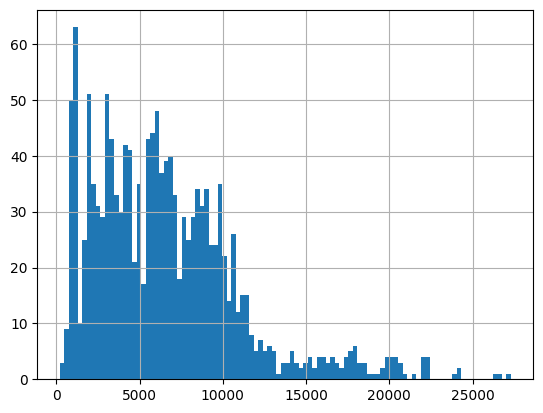

In [1183]:
merged_df['distance'].hist(bins=100)

In [1185]:
dtale.show(merged_df[['customer_geometry', "distance"]])

In [1186]:
# checkouts_df[checkouts_df['distance']>30000.0]

In [1187]:
merged_df[['customer_geometry', "distance"]].explore("distance")

In [1189]:
books_df.head(2)

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
0,hVFwAAAAQBAJ,Ogilvy on Advertising,['David Ogilvy'],Vintage,2013-09-11,['Social Science'],72.99,320,2013
1,bRY9AAAAYAAJ,Foreign Publications for Advertising American ...,['United States. Bureau of Foreign and Domesti...,['NO_PUBLISHER'],1913-01-01,['Advertising'],469.99,654,1913


In [1190]:
books_df[books_df.book_id=='TQpFnkku2poC']

,book_id,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
36,TQpFnkku2poC,Advertising Management,"['C. L. Tyagi', 'Arun Kumar']",Atlantic Publishers & Dist,2004-01-01,['Advertising'],217.0,790,2004


In [1191]:
merged_df.head(2)

,id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,library_name,library_street_address,library_city,library_region,library_postal_code,library_address,library_geometry,library_longitude,library_latitude,distance
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14,Jeanette Nelms,4942 SE 28TH AVE,PORTLAND,OREGON,...,MULTNOMAH COUNTY LIBRARY WOODSTOCK,6008 SE 49TH AVE,PORTLAND,OR,97206,"6008 SE 49TH AVE, PORTLAND, OR",POINT (-13649117.262 5697248.904),-122.61210650846269,45.47900505,3066.751994
1,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62,Melvin Jackson,2821 NE KLICKITAT ST,PORTLAND,OREGON,...,MULTNOMAH COUNTY LIBRARY,205 NE RUSSELL ST,PORTLAND,OR,97212,"205 NE RUSSELL ST, PORTLAND, OR",POINT (-13654840.942 5707125.540),-122.6635232,45.5411809,3130.805100


In [1192]:
merged_df = merged_df.rename(columns={
    'id': 'book_id'
})

In [1193]:
merged_df = merged_df.merge(books_df, on='book_id', how='left')

In [1197]:
merged_df.head(2)

,book_id,patron_id,library_id,date_checkout,date_returned,length,customer_name,customer_street_address,customer_city,customer_state,...,library_latitude,distance,book_title,book_authors,book_publisher,book_publishedDate,book_categories,book_price,book_pages,book_published_year
0,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14,Jeanette Nelms,4942 SE 28TH AVE,PORTLAND,OREGON,...,45.47900505,3066.751994,Indian Financial System 5E,['Khan'],Tata McGraw-Hill Education,2006-06-01,['NO_CATEGORY'],416.99,752,2006
1,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62,Melvin Jackson,2821 NE KLICKITAT ST,PORTLAND,OREGON,...,45.5411809,3130.805100,Advertising Management,"['C. L. Tyagi', 'Arun Kumar']",Atlantic Publishers & Dist,2004-01-01,['Advertising'],217.00,790,2004


In [1196]:
merged_df.to_pickle('data/merged_df.pickle')
merged_df.to_csv('data/merged_df.csv')